# Construire une droite d'étalonnage

On se propose de donner quelques éléments supplémentaires pour la régression linéaire, notamment pour son utilisation pour estimer une valeur (comme avec une courbe d'étalonnage). On se base ici sur un exemple de chimie : l'utilisation d'une courbe d'étalonnage reliant l'absorbance à la concentration d'une espèce colorée.

Cette partie est plus optionnelle et demande déjà une bonne compréhension des éléments précédents, notamment sur la régression linéaire et l'utilisation des fonctions Python.

## Données de mesures
Les données déjà utilisées sont disponibles en ligne. Il faudra changer le lien vers le fichier après l'avoir téléchargé

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rd


filename = "github.com/pcsi3physiquestan/donnees_exp/blob/main/lambert.dat"  # Lien vers le fichier de données
A, C, uC = np.loadtxt(filename, skiprows=1, delimiter=",", unpack=True)  # Importation des données

## Vérification visuelle de la loi linéaire
Avant de se lancer dans une régression linéaire et la simulation de Monte-Carlo, on va vérifier que le modèle affine est acceptable visuellement.

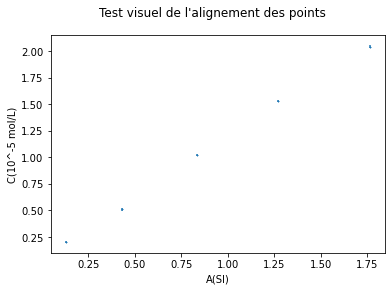

In [2]:
"""
Détermination des moyennes et écart-type pour la simulation de Monte-Carlo puis création des N échantillons
"""
n_mes = A.shape[0]  # Nombre de mesures réalisées


"""
Vérification visuelle de l'alignement (approximatifs) des points de mesure.
"""
f, ax = plt.subplots()
f.suptitle("Test visuel de l'alignement des points")
ax.set_xlabel("A(SI)")
ax.set_ylabel("C(10^-5 mol/L)")

ax.errorbar(A, C, yerr=uC, marker='+', markersize=2, linestyle='')


plt.show()


## Mise en place de la simulation de Monte-Carlo
On commence par réaliser les N échantillons simulées pour A et C. Sans plus d'information, on a choisi des distributions gaussiennes.

In [3]:
# Simulation des N tirages
N = 1000000
C_sim = rd.normal(C, uC, (N, n_mes))  # On génère directement un tableau où les colonnes correspondent à une mesure de C.


## Paramètres d'ajustement
On va donc réaliser N régressions linéaires et ainsi estimer la pente et l'ordonnée à l'origine avec leurs incertitudes. On obtiendra aussi un jeu simulé de N valeurs de la pente et de l'ordonnée à l'origine qui nous servirons ensuite.

-----------------------------
Pente = 1.1398 +/- 0.0095 10^-5 mol/L
Ordonnée à l'origine = 0.0529 +/- 0.0088 10^-5 mol/L
-----------------------------


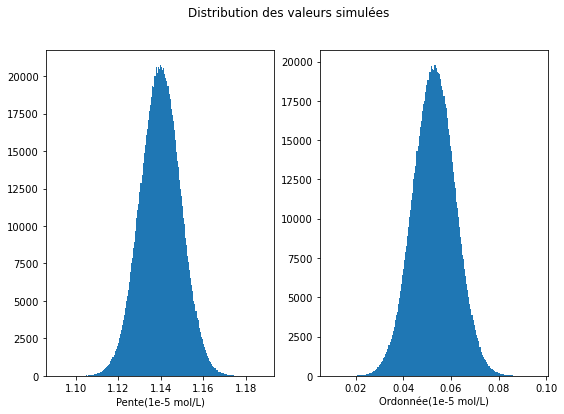

In [4]:
# Réalisation des régression linéaire. polyfit peut faire les N régressions, tant que les abscisses ne changent pas
# Ce qui est le cas ici
# On doit par contre transposer le tableau des valeurs de C (inverser lignes et colonnes)
p_sim = np.polyfit(A, C_sim.transpose(), 1)


pente_m = np.mean(p_sim[0])
ordo_m = np.mean(p_sim[1])
pente_u = np.std(p_sim[0], ddof=1)
ordo_u = np.std(p_sim[1], ddof=1)

print("-----------------------------")
print("Pente = {:.4f} +/- {:.4f} 10^-5 mol/L".format(pente_m, pente_u))
print("Ordonnée à l'origine = {:.4f} +/- {:.4f} 10^-5 mol/L".format(ordo_m, ordo_u))
print("-----------------------------")

"""
Histogrammes des valeurs simulées
"""
f, ax = plt.subplots(1, 2, figsize=(9, 6))
f.suptitle("Distribution des valeurs simulées")

# Pente
ax[0].set_xlabel('Pente(1e-5 mol/L)')
ax[0].hist(p_sim[0], bins='rice')

# Pente
ax[1].set_xlabel('Ordonnée(1e-5 mol/L)')
ax[1].hist(p_sim[1], bins='rice')

plt.show()


On remarque que la droite ajustée ne passe pas par l'origine, même en tenant compte des incertitudes de mesures. Heureusement, la régression linéaire permet de travailler malgré le biais.

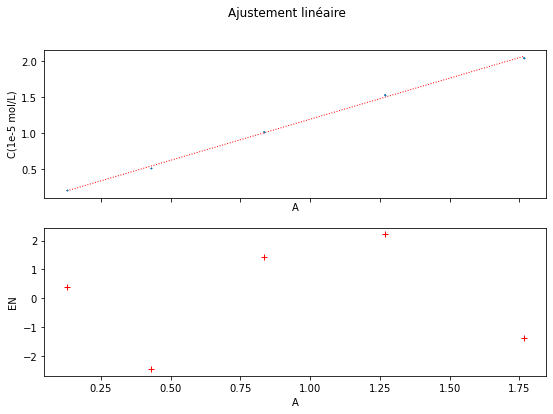

In [5]:
"""
Vérification de l'ajustement par tracé graphique et calcul des écarts normalisés.
"""
f, ax = plt.subplots(2, 1, figsize=(9, 6), sharex='col')  # Tracé en partageant les abscisses sur les deux axes.
f.suptitle("Ajustement linéaire")

"""
Tracé de la droite d'ajustment
On va pousser plus loin l'analyse en estimant l'incertitude sur les points ajustés.
On s'en servira dans les écarts normalisés notamment.
"""

C_adj_sim = np.zeros((N, n_mes))
for i in range(n_mes):
    C_adj_sim[:, i] = p_sim[0] * A[i] + p_sim[1]  # Calcul des N valeurs ajustées pour chaque distance


C_adj_m = C_adj_sim.mean(axis=0)  # Moyenne sur les N valeurs (suivant les colonnes :  axis = 0)
C_adj_u = C_adj_sim.std(ddof=1, axis=0)  # Moyenne sur les N valeurs (suivant les colonnes :  axis = 0)

ax[0].set_xlabel("A")
ax[0].set_ylabel("C(1e-5 mol/L)")
ax[0].errorbar(A, C, yerr=uC, marker='+', markersize=2, linestyle='')
ax[0].plot(A, C_adj_m, linestyle=':', linewidth=1, color='red')


"""Tracé des écarts normalisés"""
en = (C - C_adj_m) / (np.sqrt(uC ** 2 + C_adj_u ** 2))


ax[1].set_xlabel("A")
ax[1].set_ylabel("EN")
ax[1].plot(A, en, linestyle='', marker='+', color='red')


plt.show()


L'analyse de la droite d'ajustement est délicate car les incertitudes sont très faibles. L'analyse des écarts normalisés ne laisse par contre pas de doute, le modèle ajusté est compatible avec les résultats. One ne cherche pas vraiment une valeur particulière de la pente (même si le coefficient du bleu de patenté est tabulé). On va maintenant pouvoir utiliser cette droite d'ajustement.



## Utilisation de la droite d'ajustement.
On se propose d'utiliser la droite d'ajustement comme courbe d'étalonnage pour déterminer une concentration à partir dela mesure d'une absorbance

Si la détermination de $C$ connaissant la pente et l'ordonnée à l'origine précédente ne pose pas de problème. On va voir comme utiliser les valeurs simulées précédentes pour estimer les incertitudes de mesure.

On montrera aussi graphiquement ces incertitudes de mesure sur la droite d'étalonnage. Pour produire une courbe d'étalonnage __avec incertitudes de mesures__.

### Détermination la concentration pour une mesure

On commence par supposer qu'on a mesuré l'abosrbance $A$. On prendra $A = 0.523$ pour l'exemple. On va simuler le calcul de $C$ N fois à partir des valeurs simulées de la pente et de l'ordonnées à l'origine ($C = aA + b$). Les statistiques obtenues nous permettront d'obtenir une estimation de $C$ et de son incertitude.

In [6]:
A_test = 0.523  # Distance en centimètre
C_sim = p_sim[0] * A_test + p_sim[1]  # Simulation des concentrations

C_m = np.mean(C_sim)  # Estimation de la concentration moyenne
C_u = np.std(C_sim, ddof=1)  # Estimation de l'écart-type

print("-----------------------------")
print("Concentration estimée = ({:.3f} +/- {:.3f}) 10^-5 mol/L".format(C_m, C_u))
print("-----------------------------")



-----------------------------
Concentration estimée = (0.649 +/- 0.006) 10^-5 mol/L
-----------------------------


### Courbe d'étalonnage avec incertitude
Pour représenter la courbe avec incertitude (on imagine qu'elle serait donnée ensuite à un autre expérimentateur qui n'aurait pas à faire cet étalonnage), on va représenter les _fuseaux_ donnant les valeurs $C_{mes} \pm u(C)$ estimé pour chaque valeur d'absorbance __dans la zone d'étude__.

```{margin}
Il est délicat d'extrapoler en dessous de $A_{min}$ et au dessus de $A_{max}$, des phénomènes supplémentaires peuvent rendre faux le modèle affine. On ne l'a pas testé.
```

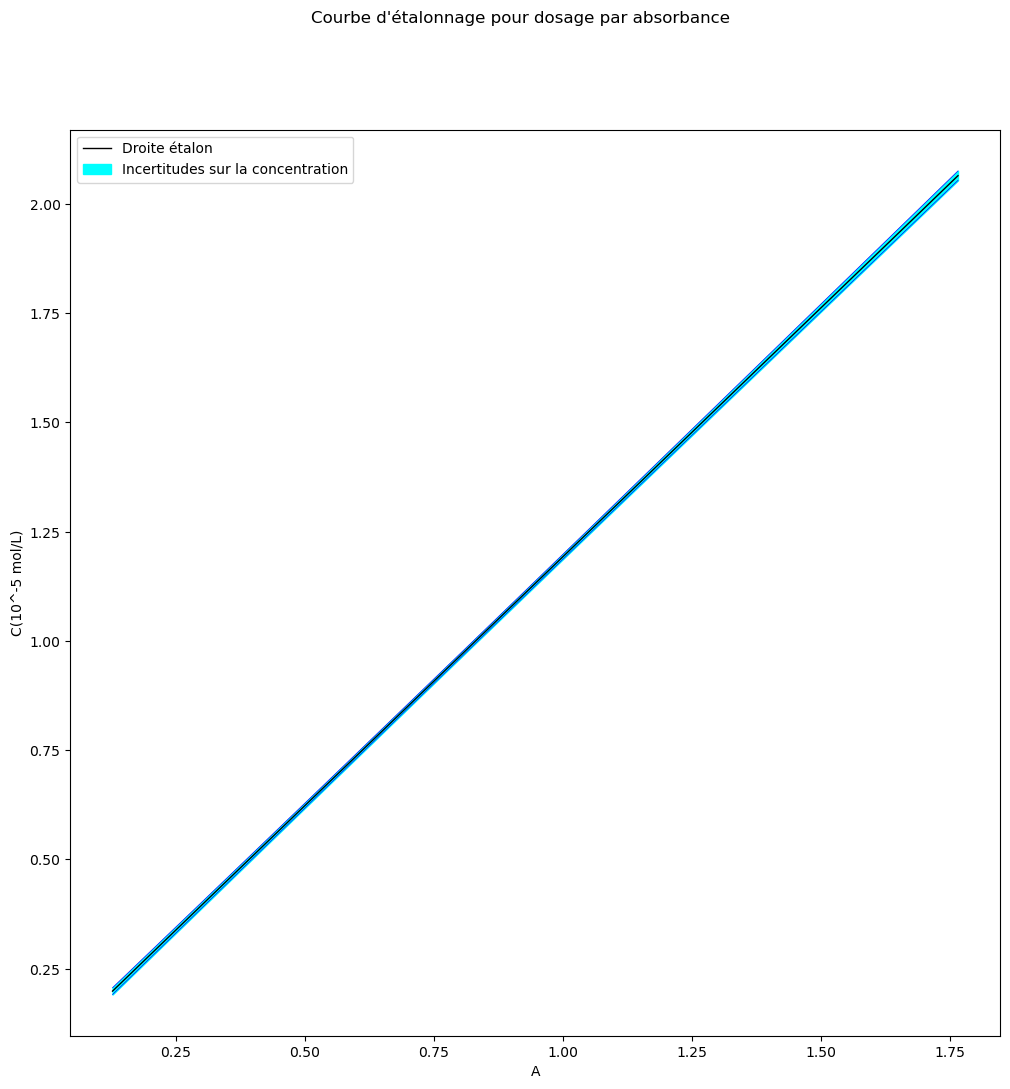

In [7]:
NA = 100  # Nombre de valeurs d'absorbance qu'on va tester
A_courbe = np.linspace(min(A), max(A), NA)  # On trace les fuseaux pour la zone d'étude.

"""
On reprend la même méthode que précédemment mais pour chaque valeur de A. On va donc obtenir 
un vecteur de valeurs pour C et son incertitude
"""

C_courbe_sim = np.zeros((NA, N))  # Tableau de 0 où on va stocker les valeurs simulées de C pour chaque absorbance
for i in range(NA):
    C_courbe_sim[i] = p_sim[0] * A_courbe[i] + p_sim[1]  # Simulation des concentrations pour chaque valeur de A

C_courbe_m = np.mean(C_courbe_sim, axis=1)  # Estimation de la concentration moyenne pour chaque valeur de A (par colonne)
C_courbe_u = np.std(C_courbe_sim, ddof=1, axis=1)  # Estimation de l'écart-type pour chaque valeur de A (par colonne=)

C_mean = pente_m * A_courbe + ordo_m  # Droite ajustée
C_min = C_courbe_m - C_courbe_u # Limite basse des valeurs données par l'incertitude
C_max = C_courbe_m + C_courbe_u # Limite basse des valeurs données par l'incertitude

"""
Tracé graphique de la droite d'étalonnage avec le fuseau donnant les incertitudes
"""
f, ax = plt.subplots(figsize=(12,12), dpi=100)
f.suptitle("Courbe d'étalonnage pour dosage par absorbance")
ax.set_xlabel("A")
ax.set_ylabel("C(10^-5 mol/L)")

ax.plot(A_courbe, C_mean, label="Droite étalon", color='black', linewidth=1)  # Droite d'ajustement

# Première méthode : on trace les deux courbes hautes et basses
ax.plot(A_courbe, C_min, color='blue', linewidth=.5)  # Cmes - u(C)
ax.plot(A_courbe, C_max, color='blue', linewidth=.5)  # Cmes + u(C)

# Deuxième méthode : la fonction fill_between, remplit de couleur l'espace entre 2 courbes
ax.fill_between(A_courbe, C_min, C_max, color='cyan', linewidth=1, label="Incertitudes sur la concentration")

ax.legend()
plt.show()
